## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import contractions
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import re
import string
from tqdm import tqdm
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

stopwords = set(stopwords.words('english'))

c:\Users\fahrizain\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
train = pd.read_csv('../data/processed/trainset-feature-extracted.csv')
test = pd.read_csv('../data/processed/testset-feature-extracted.csv')
len(train), len(test)

(159567, 153159)

In [3]:
test_used = test[test['is_toxic'] >= 0]
len(test_used)

63975

## Prepare Dataset

In [4]:
train_sent = train.processed.tolist()
test_sent = test.processed.tolist()

In [5]:
# get all processed texts
sentences = ' '.join(train_sent + test_sent)
# obtain list of words
words = sentences.split()

# check list
words[:10]

['explanation',
 'edits',
 'made',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'reverted',
 'vandalism',
 'closure']

In [6]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [7]:
# filter and replace test set cz some of them aren't used for evaluation
test_sent = test_used.processed.to_list()
len(test_sent)

63975

In [8]:
# encode words
train_enc = [[word2int[word] for word in trsent.split()] for trsent in tqdm(train_sent)]
test_enc = [[word2int[word] for word in tssent.split()] for tssent in tqdm(test_sent)]

# look first 10 words of top-3 encoded sentences
for i in range(3):
    print(train_enc[i][:10])

100%|██████████| 63975/63975 [00:01<00:00, 60019.27it/s]

[516, 64, 57, 588, 3978, 8581, 699, 259, 128, 5520]
[5521, 1089, 322, 2480, 4319, 2381, 27, 6, 766, 2880]
[330, 266, 53, 173, 17, 175, 238, 2209, 408, 390]


In [9]:
# padding sequences

def pad_features(sentences, pad_id, seq_length=128):
    # make a template for output
    features = np.full((len(sentences), seq_length), pad_id, dtype=int)

    # trim sentence and assign paddings
    for i, row in enumerate(sentences):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256

# pad features
train_features = pad_features(train_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)
test_features = pad_features(test_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(train_features) == len(train_enc)
assert len(train_features[0]) == seq_length
assert len(test_features) == len(test_enc)
assert len(test_features[0]) == seq_length

train_features[:3, :10]

array([[ 516,   64,   57,  588, 3978, 8581,  699,  259,  128, 5520],
       [5521, 1089,  322, 2480, 4319, 2381,   27,    6,  766, 2880],
       [ 330,  266,   53,  173,   17,  175,  238, 2209,  408,  390]])

In [10]:
# get labels as numpy
train_labels = train.is_toxic.to_numpy()
test_labels = test_used.is_toxic.to_numpy()
train_labels, test_labels

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 1, 0], dtype=int64))

In [11]:
# get additional feature
train_fe = train.iloc[:, -2:].to_numpy()
test_fe = test_used.iloc[:, -2:].to_numpy()

In [12]:
# train val split size
train_size = .7
val_size = .3

# get split index
split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
train_idx, val_idx = next(split.split(train_features, train_labels))

# make train - val set
train_features, val_features = train_features[train_idx], train_features[val_idx]
train_labels, val_labels = train_labels[train_idx], train_labels[val_idx]
train_fe, val_fe = train_fe[train_idx], train_fe[val_idx]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_features.shape))
print('Validation set: {}'.format(val_features.shape))
print('Test set: {}'.format(test_features.shape))

Feature Shapes:
Train set: (111696, 256)
Validation set: (47871, 256)
Test set: (63975, 256)


In [13]:
# check data split proportion
print(len(train_labels[train_labels == 0]), len(train_labels[train_labels == 1]))
print(len(val_labels[val_labels == 0]), len(val_labels[val_labels == 1]))
print(len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))

104791 6905
44911 2960
59574 4401


In [14]:
# define batch size
batch_size = 32

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
valset = TensorDataset(torch.from_numpy(val_features), torch.from_numpy(val_labels))
testset = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(valset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [15]:
# check our batches
dataiter = iter(trainloader)
X, y = dataiter.next()

print('Sample batch size: ', X.size())      # batch_size, seq_length
print('Sample batch input: \n', X)
print()
print('Sample label size: ', y.size())      # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([32, 256])
Sample batch input: 
 tensor([[34081,   743, 34081,  ...,     0,     0,     0],
        [18099,   140,   194,  ...,     0,     0,     0],
        [    4,    63,     3,  ...,     0,     0,     0],
        ...,
        [    9,    21,  6360,  ...,     0,     0,     0],
        [  442,     5,  2351,  ...,     0,     0,     0],
        [ 4255, 59154,  6739,  ...,     0,     0,     0]], dtype=torch.int32)

Sample label size:  torch.Size([32])
Sample label input: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0])


## Modelling
1. Build network architecture
2. Define model hyperparameters
3. Setup training config
4. Write training-validation loop
5. Plot Loss
6. Inference on test set
7. Evaluation metrics

In [16]:
# model architecture

class ToxicModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=300, n_layers=2, dropout=0.2):
        super(ToxicModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # convert feature type to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ = self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

In [17]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
# model hyperparameters
vocab_size = len(word2int)
output_size = 1
embedding_size = 128
hidden_size = 128
n_layers = 2
dropout = 0.25

# model initialization
model = ToxicModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

ToxicModel(
  (embedding): Embedding(284429, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [19]:
# training config
lr = 0.001 # 1e-3
criterion = nn.BCELoss() # we use BCELoss cz we have binary classification case
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 5
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5    # early stop

In [20]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted
    
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0

    with  torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted
        
    history['val_loss'].append(val_loss / len(valloader))
    history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), '../models/toxic_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:   0%|          | 0/5 [11:41<?, ?it/s, Val Loss: 0.231 | Val Acc: 0.939]

Epoch 1/5 | Train Loss: 0.235 Train Acc: 0.938 | Val Loss: 0.231 Val Acc: 0.939


Training:  20%|██        | 1/5 [23:44<46:55, 703.99s/it, Val Loss: 0.097 | Val Acc: 0.968]

Epoch 2/5 | Train Loss: 0.137 Train Acc: 0.960 | Val Loss: 0.097 Val Acc: 0.968


Training:  40%|████      | 2/5 [35:36<35:46, 715.52s/it, Val Loss: 0.081 | Val Acc: 0.972]

Epoch 3/5 | Train Loss: 0.069 Train Acc: 0.976 | Val Loss: 0.081 Val Acc: 0.972


Training:  80%|████████  | 4/5 [47:37<11:55, 715.52s/it, Training batch 1/3491]           

Epoch 4/5 | Train Loss: 0.048 Train Acc: 0.983 | Val Loss: 0.084 Val Acc: 0.971
[WARNING] Validation loss did not improved (0.081 --> 0.084)


Training: 100%|██████████| 5/5 [59:32<00:00, 714.44s/it, Val Loss: 0.093 | Val Acc: 0.970]

Epoch 5/5 | Train Loss: 0.033 Train Acc: 0.989 | Val Loss: 0.093 Val Acc: 0.970
[WARNING] Validation loss did not improved (0.081 --> 0.093)


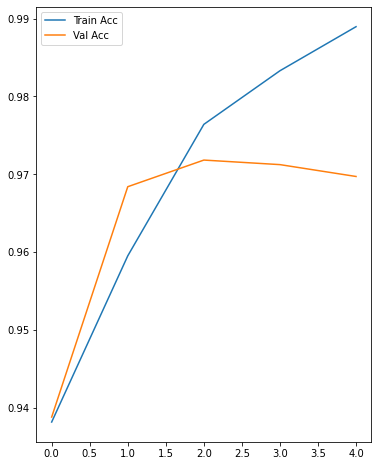

In [21]:
# plot acc
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

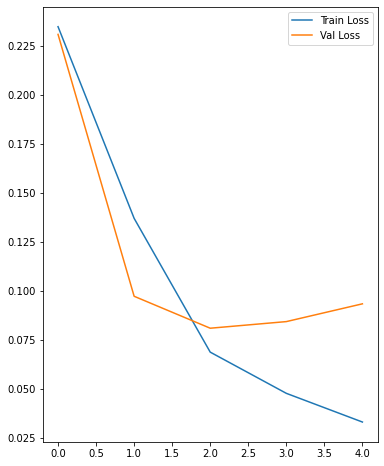

In [22]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

## Inference

In [23]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy {test_acc / len(testloader):.4f}, Loss: {test_loss / len(testloader):.4f}')

Inference: 100%|██████████| 2000/2000 [01:05<00:00, 30.50it/s]

Accuracy 0.9308, Loss: 0.1782


## Evaluation Metrics

In [24]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     57221
           1       0.76      0.50      0.60      6754

    accuracy                           0.93     63975
   macro avg       0.85      0.74      0.78     63975
weighted avg       0.92      0.93      0.92     63975



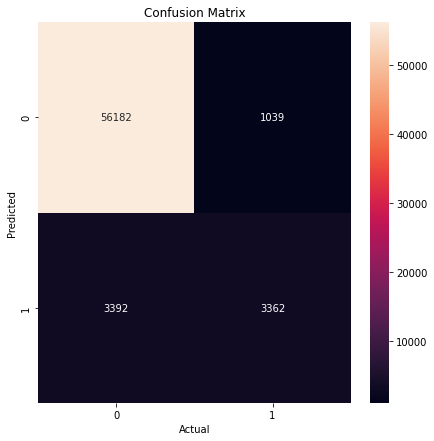

In [25]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()